In this notebook we see how a LIF neuron responds to various types of input currents and try to learn something maybe?

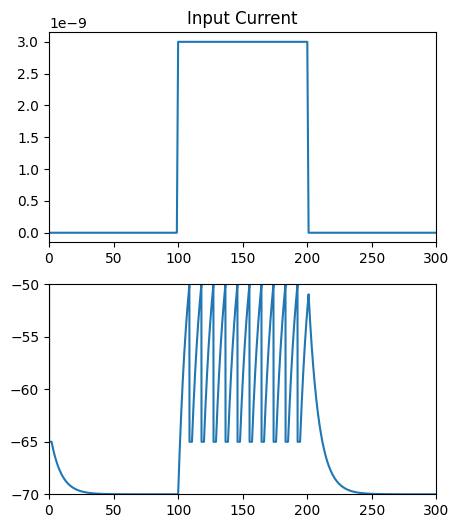

In [40]:
from brian2 import *
import matplotlib.pyplot as plt
import numpy as np

def lif_neuron(curr, run_time, v_rest=-70*mV, v_reset=-65*mV, threshold=-50*mV, membrane_r=10.*Mohm, time_constant=8.*ms, refractory_period=2.0*ms):
    eqs = '''
    dv/dt = ( -(v - v_rest) + membrane_r * curr(t, i) ) / time_constant : volt (unless refractory)
    '''
    G = NeuronGroup(
    1, eqs, threshold='v > threshold', 
    reset="v = v_reset", method="linear", refractory=refractory_period)
    M = StateMonitor(G, True, True)
    S = SpikeMonitor(G)
    run(run_time)
    return M, S
    
tmp = np.zeros((300, 1)) * amp
tmp[100: 200 + 1, 0] = 3*namp
curr = TimedArray(tmp, dt=1. * ms)

start_scope()

M, S = lif_neuron(curr, 300*ms)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 6))

ax1.plot(curr)
ax1.set_xlim(0, 300)
ax1.set_title("Input Current")

ax2.plot(M.t/ms, M.v[0]/mV)
ax2.set_xlim(0, 300)
ax2.set_ylim(-70, -50);

Basic step current, basic spiking behaviour. Frequency increases with magnitude of input current, we'll explore this relationship later

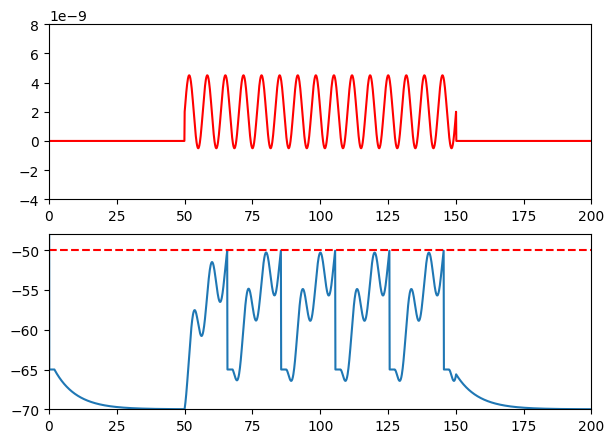

In [37]:
from neurodynex3.tools import input_factory, plot_tools

start_scope()

curr = input_factory.get_sinusoidal_current(
        500, 1500, unit_time=0.1 * ms,
        amplitude=2.5 * namp, frequency=150 * Hz, direct_current=2. * namp)

M, S = lif_neuron(curr, 200*ms)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 5))

t_range = np.linspace(0, 200, 2000) *ms
current_values = curr(t_range, 0)

ax1.plot(t_range/ms, current_values, color="red")
ax1.set_xlim(0, 200)
ax1.set_ylim(-4*namp, 8*namp)

ax2.plot(M.t/ms, M.v[0]/mV)
ax2.set_xlim(0, 200)
ax2.set_ylim(-70, -48);
ax2.axhline(-50, color="red", ls="--");

Now we observe the relationship between spike frequency and input current.

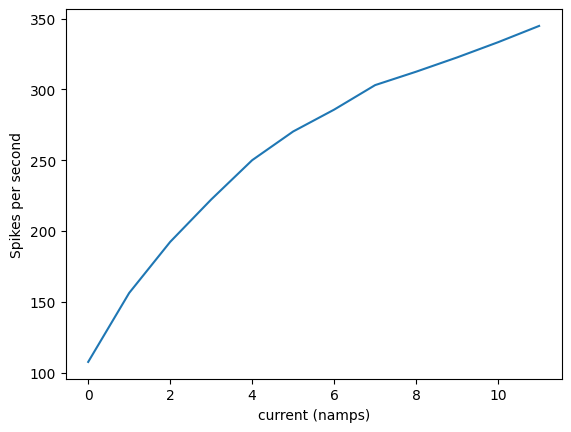

In [38]:
times = [t/ms for t in S.t]
intervals = [t - s for s, t in zip(times, times[1:])]
np.mean(intervals)

means = []

for hello in range(3, 15):
    start_scope()

    tmp = np.zeros((300, 1)) * amp
    tmp[0:] = hello*namp
    curr = TimedArray(tmp, dt=1. * ms)
    
    M, S = lif_neuron(curr, 300*ms)

    times = [t for t in S.t]
    intervals = [t - s for s, t in zip(times, times[1:])]
    mean_time = np.mean(intervals)
    means.append(mean_time)

plot([1/n for n in means])
plt.xlabel("current (namps)")
plt.ylabel("Spikes per second");

As input current is increased linearly, the spike frquency increases logarithmically, leading to diminishing returns. IDK if this means anything, but here it is anyways.

Now we connect a Poisson input to the neuron. Poisson neurons more accurately represent the spiking behaviour of biological neurons, and are used extensively in large simulations as external neurons for independent random input.

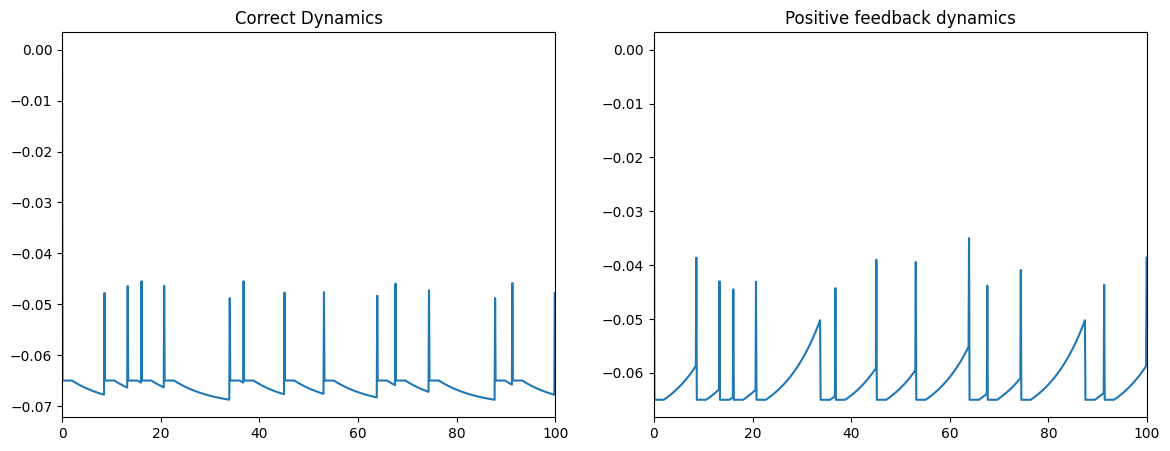

In [35]:
start_scope()

v_rest=-70*mV
v_reset=-65*mV
threshold=-50*mV 
membrane_r=10.*Mohm 
time_constant=8.*ms 
refractory_period=2.0*ms

P = PoissonGroup(1, rates=200*Hz)

eqs = '''
    dv/dt = (-(v - v_rest))/ time_constant : volt (unless refractory)
'''
eqs_1 = '''
    dv/dt = ((v - v_rest))/ time_constant : volt (unless refractory)
'''

G = NeuronGroup(1, eqs, threshold='v>threshold', reset='v=v_reset', method="exact", refractory=refractory_period)
G_1 = NeuronGroup(1, eqs_1, threshold='v>threshold', reset='v=v_reset', method="exact", refractory=refractory_period)

S = Synapses(P, G, on_pre='v += 20* mV')
S_1 = Synapses(P, G_1, on_pre='v += 20* mV')
S.connect()
S_1.connect()

M = StateMonitor(G, 'v', record=True)
M_1 = StateMonitor(G_1, 'v', record=True)
Sp = SpikeMonitor(G)
Sp_1 = SpikeMonitor(G_1)

run(100*ms)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.plot(M.t/ms, M.v[0])
ax1.set_xlim(0, 100);
ax1.set_title("Correct Dynamics")

ax2.plot(M_1.t/ms, M_1.v[0])
ax2.set_xlim(0, 100)
ax2.set_title("Positive feedback dynamics");

I noticed something interesting here, If i change the dynamics of the LIF model to $\frac{du}{dt} = ([u(t) - u_{rest}] + RI(t)) / \tau _m$, It resembles real-world spike data somewhat more closely.  
It specifically resembles the spikes shown by exponential integrate-and-fire models, i assume because of similar behaviour when it is about to spike, with the relatively gradual rise and sudden fall.